🚀 Agent Tool Patterns and Best Practices¶
Welcome to Day-2 of the Kaggle 5-day Agents course!

In the previous notebook, you learned how to add custom Python functions as tools to your agent. In this notebook, we'll take the next step: consuming external MCP services and handling long-running operations.

In this notebook, you'll learn how to:

✅ Connect to external MCP servers
✅ Implement long-running operations that can pause agent execution for external input
✅ Build resumable workflows that maintain state across conversation breaks
✅ Understand when and how to use these patterns

⚙️ Section 1: Setup¶
1.1: Install dependencies
The Kaggle Notebooks environment includes a pre-installed version of the google-adk library for Python and its required dependencies.

To install and use ADK in your own Python development environment outside of this course, you can do so by running:

pip install google-adk
1.2: Configure your Gemini API Key
This notebook uses the Gemini API, which requires an API key.

1. Get your API key

If you don't have one already, create an API key in Google AI Studio.

2. Add the key to Kaggle Secrets

Next, you will need to add your API key to your Kaggle Notebook as a Kaggle User Secret.

In the top menu bar of the notebook editor, select Add-ons then Secrets.
Create a new secret with the label GOOGLE_API_KEY.
Paste your API key into the "Value" field and click "Save".
Ensure that the checkbox next to GOOGLE_API_KEY is selected so that the secret is attached to the notebook.
3. Authenticate in the notebook

Run the cell below to access the GOOGLE_API_KEY you just saved and set it as an environment variable for the notebook to use:

In [1]:
import os
#from kaggle_secrets import UserSecretsClient

try:
   #GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
    GOOGLE_API_KEY=os.environ["GOOGLE_API_KEY"]  
    print("✅ Gemini API key setup complete.")
except Exception as e:
    print(
        f"🔑 Authentication Error: Please make sure you have added 'GOOGLE_API_KEY' to your Kaggle secrets. Details: {e}"
    )

✅ Gemini API key setup complete.


1.3: Import ADK components
Now, import the specific components you'll need from the Agent Development Kit. This keeps your code organized and ensures we have access to the necessary building blocks.

In [2]:
import uuid
from google.genai import types

from google.adk.agents import LlmAgent
from google.adk.models.google_llm import Gemini
from google.adk.runners import Runner
from google.adk.sessions import InMemorySessionService

from google.adk.tools.mcp_tool.mcp_toolset import McpToolset
from google.adk.tools.tool_context import ToolContext
from google.adk.tools.mcp_tool.mcp_session_manager import StdioConnectionParams
from mcp import StdioServerParameters

from google.adk.apps.app import App, ResumabilityConfig
from google.adk.tools.function_tool import FunctionTool

print("✅ ADK components imported successfully.")

✅ ADK components imported successfully.


1.4: Configure Retry Options
When working with LLMs, you may encounter transient errors like rate limits or temporary service unavailability. Retry options automatically handle these failures by retrying the request with exponential backoff.

In [3]:
retry_config = types.HttpRetryOptions(
    attempts=5,  # Maximum retry attempts
    exp_base=7,  # Delay multiplier
    initial_delay=1,
    http_status_codes=[429, 500, 503, 504],  # Retry on these HTTP errors
)

🧰 Section 2: Model Context Protocol
So far, you have learned how to create custom functions for your agents. But connecting to external systems (GitHub, databases, Slack) requires writing and maintaining API clients.

Model Context Protocol (MCP) is an open standard that lets agents use community-built integrations. Instead of writing your own integrations and API clients, just connect to an existing MCP server.

MCP enables agents to:

✅ Access live, external data from databases, APIs, and services without custom integration code
✅ Leverage community-built tools with standardized interfaces
✅ Scale capabilities by connecting to multiple specialized servers

2.1: How MCP Works
MCP connects your agent (the client) to external MCP servers that provide tools:

MCP Server: Provides specific tools (like image generation, database access)
MCP Client: Your agent that uses those tools
All servers work the same way - standardized interface

Architecture:

┌──────────────────┐
│   Your Agent     │
│   (MCP Client)   │
└────────┬─────────┘
         │
         │ Standard MCP Protocol
         │
    ┌────┴────┬────────┬────────┐
    │         │        │        │
    ▼         ▼        ▼        ▼
┌────────┐ ┌─────┐ ┌──────┐ ┌─────┐
│ GitHub │ │Slack│ │ Maps │ │ ... │
│ Server │ │ MCP │ │ MCP  │ │     │
└────────┘ └─────┘ └──────┘ └─────┘

2.2: Using MCP with Your Agent¶
The workflow is simple:

Choose an MCP Server and tool
Create the MCP Toolset (configure connection)
Add it to your agent
Run and test the agent
Step 1: Choose MCP Server

For this demo, we'll use the Everything MCP Server - an npm package (@modelcontextprotocol/server-everything) designed for testing MCP integrations.

It provides a getTinyImage tool that returns a simple test image (16x16 pixels, Base64-encoded). Find more servers: modelcontextprotocol.io/examples

‼️ NOTE: This is a demo server to learn MCP. In production, you'll use servers for Google Maps, Slack, Discord, etc.

Step 2: Create the MCP Toolset

The McpToolset is used to integrate an ADK Agent with an MCP Server.

What the code does:

Uses npx (Node package runner) to run the MCP server
Connects to @modelcontextprotocol/server-everything
Filters to only use the getTinyImage tool (the server has others, but we only need this one)

In [4]:
# MCP integration with Everything Server
mcp_image_server = McpToolset(
    connection_params=StdioConnectionParams(
        server_params=StdioServerParameters(
            command="npx",  # Run MCP server via npx
            args=[
                "-y",  # Argument for npx to auto-confirm install
                "@modelcontextprotocol/server-everything",
            ],
            tool_filter=["getTinyImage"],
        ),
        timeout=30,
    )
)

print("✅ MCP Tool created")

✅ MCP Tool created


Behind the scenes:¶
Server Launch: ADK runs npx -y @modelcontextprotocol/server-everything
Handshake: Establishes stdio communication channel
Tool Discovery: Server tells ADK: "I provide getTinyImage" functionality
Integration: Tools appear in agent's tool list automatically
Execution: When agent calls getTinyImage(), ADK forwards to MCP server
Response: Server result is returned to agent seamlessly
Why This Matters: You get instant access to tools without writing integration code!

Step 3: Add MCP tool to agent

Let's add the mcp_server to the agent's tool array and update the agent's instructions to handle requests to generate tiny images.

In [5]:
# Create image agent with MCP integration
image_agent = LlmAgent(
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    name="image_agent",
    instruction="Use the MCP Tool to generate images for user queries",
    tools=[mcp_image_server],
)

Create the runner:

In [6]:
from google.adk.runners import InMemoryRunner

runner = InMemoryRunner(agent=image_agent)

Step 4: Test the agent

Ask the agent to generate an image. Watch it use the MCP tool:

In [14]:
import sys
import asyncio

if sys.platform == "win32":
    asyncio.set_event_loop_policy(asyncio.WindowsProactorEventLoopPolicy())

# Aquí el resto de tus importaciones y código
# from google.adk.runners import InMemoryRunner # o tu implementación local
# ...

response = await runner.run_debug("Provide a sample tiny image", verbose=True)


 ### Continue session: debug_session_id

User > Provide a sample tiny image


UnsupportedOperation: fileno

Display the image:

The server returns base64-encoded image data. Let's decode and display it:

In [15]:
from IPython.display import display, Image as IPImage
import base64

for event in response:
    if event.content and event.content.parts:
        for part in event.content.parts:
            if hasattr(part, "function_response") and part.function_response:
                for item in part.function_response.response.get("content", []):
                    if item.get("type") == "image":
                        display(IPImage(data=base64.b64decode(item["data"])))

NameError: name 'response' is not defined

2.3: Extending to Other MCP Servers
The same pattern works for any MCP server - only the connection_params change. Here are some examples:

👉 Kaggle MCP Server - For dataset and notebook operations
Kaggle provides an MCP server that lets your agents interact with Kaggle datasets, notebooks, and competitions.

Connection example:

In [16]:
McpToolset(
    connection_params=StdioConnectionParams(
        server_params=StdioServerParameters(
            command='npx',
            args=[
                '-y',
                'mcp-remote',
                'https://www.kaggle.com/mcp'
            ],
        ),
        timeout=30,
    )
)

What it provides:

📊 Search and download Kaggle datasets
📓 Access notebook metadata
🏆 Query competition information etc.,
Learn more: Kaggle MCP Documentation

👉 GitHub MCP Server - For PR/Issue analysis

In [17]:
McpToolset(
    connection_params=StreamableHTTPServerParams(
        url="https://api.githubcopilot.com/mcp/",
        headers={
            "Authorization": f"Bearer {GITHUB_TOKEN}",
            "X-MCP-Toolsets": "all",
            "X-MCP-Readonly": "true"
        },
    ),
)

NameError: name 'StreamableHTTPServerParams' is not defined

More resources: ADK Third-party Tools Documentation

🔄 Section 3: Long-Running Operations (Human-in-the-Loop)
So far, all tools execute and return immediately:

User asks → Agent calls tool → Tool returns result → Agent responds

But what if your tools are long-running or you need human approval before completing an action?

Example: A shipping agent should ask for approval before placing a large order.

User asks → Agent calls tool → Tool PAUSES and asks human → Human approves → Tool completes → Agent responds

This is called a Long-Running Operation (LRO) - the tool needs to pause, wait for external input (human approval), then resume.

When to use Long-Running Operations:

💰 Financial transactions requiring approval (transfers, purchases)
🗑️ Bulk operations (delete 1000 records - confirm first!)
📋 Compliance checkpoints (regulatory approval needed)
💸 High-cost actions (spin up 50 servers - are you sure?)
⚠️ Irreversible operations (permanently delete account)
3.1: What We're Building Today
Let's build a shipping coordinator agent with one tool that:

Auto-approves small orders (≤5 containers)
Pauses and asks for approval on large orders (>5 containers)
Completes or cancels based on the approval decision
This demonstrates the core long-running operation pattern: pause → wait for human input → resume.

3.2: The Shipping Tool with Approval Logic
Here's the complete function.

The ToolContext Parameter
Notice the function signature includes tool_context: ToolContext. ADK automatically provides this object when your tool runs. It gives you two key capabilities:

Request approval: Call tool_context.request_confirmation()
Check approval status: Read tool_context.tool_confirmation

In [18]:
LARGE_ORDER_THRESHOLD = 5


def place_shipping_order(
    num_containers: int, destination: str, tool_context: ToolContext
) -> dict:
    """Places a shipping order. Requires approval if ordering more than 5 containers (LARGE_ORDER_THRESHOLD).

    Args:
        num_containers: Number of containers to ship
        destination: Shipping destination

    Returns:
        Dictionary with order status
    """

    # -----------------------------------------------------------------------------------------------
    # -----------------------------------------------------------------------------------------------
    # SCENARIO 1: Small orders (≤5 containers) auto-approve
    if num_containers <= LARGE_ORDER_THRESHOLD:
        return {
            "status": "approved",
            "order_id": f"ORD-{num_containers}-AUTO",
            "num_containers": num_containers,
            "destination": destination,
            "message": f"Order auto-approved: {num_containers} containers to {destination}",
        }

    # -----------------------------------------------------------------------------------------------
    # -----------------------------------------------------------------------------------------------
    # SCENARIO 2: This is the first time this tool is called. Large orders need human approval - PAUSE here.
    if not tool_context.tool_confirmation:
        tool_context.request_confirmation(
            hint=f"⚠️ Large order: {num_containers} containers to {destination}. Do you want to approve?",
            payload={"num_containers": num_containers, "destination": destination},
        )
        return {  # This is sent to the Agent
            "status": "pending",
            "message": f"Order for {num_containers} containers requires approval",
        }

    # -----------------------------------------------------------------------------------------------
    # -----------------------------------------------------------------------------------------------
    # SCENARIO 3: The tool is called AGAIN and is now resuming. Handle approval response - RESUME here.
    if tool_context.tool_confirmation.confirmed:
        return {
            "status": "approved",
            "order_id": f"ORD-{num_containers}-HUMAN",
            "num_containers": num_containers,
            "destination": destination,
            "message": f"Order approved: {num_containers} containers to {destination}",
        }
    else:
        return {
            "status": "rejected",
            "message": f"Order rejected: {num_containers} containers to {destination}",
        }


print("✅ Long-running functions created!")

✅ Long-running functions created!


3.3: Understanding the Code
Now that you've seen the complete function, let's break down how it works.

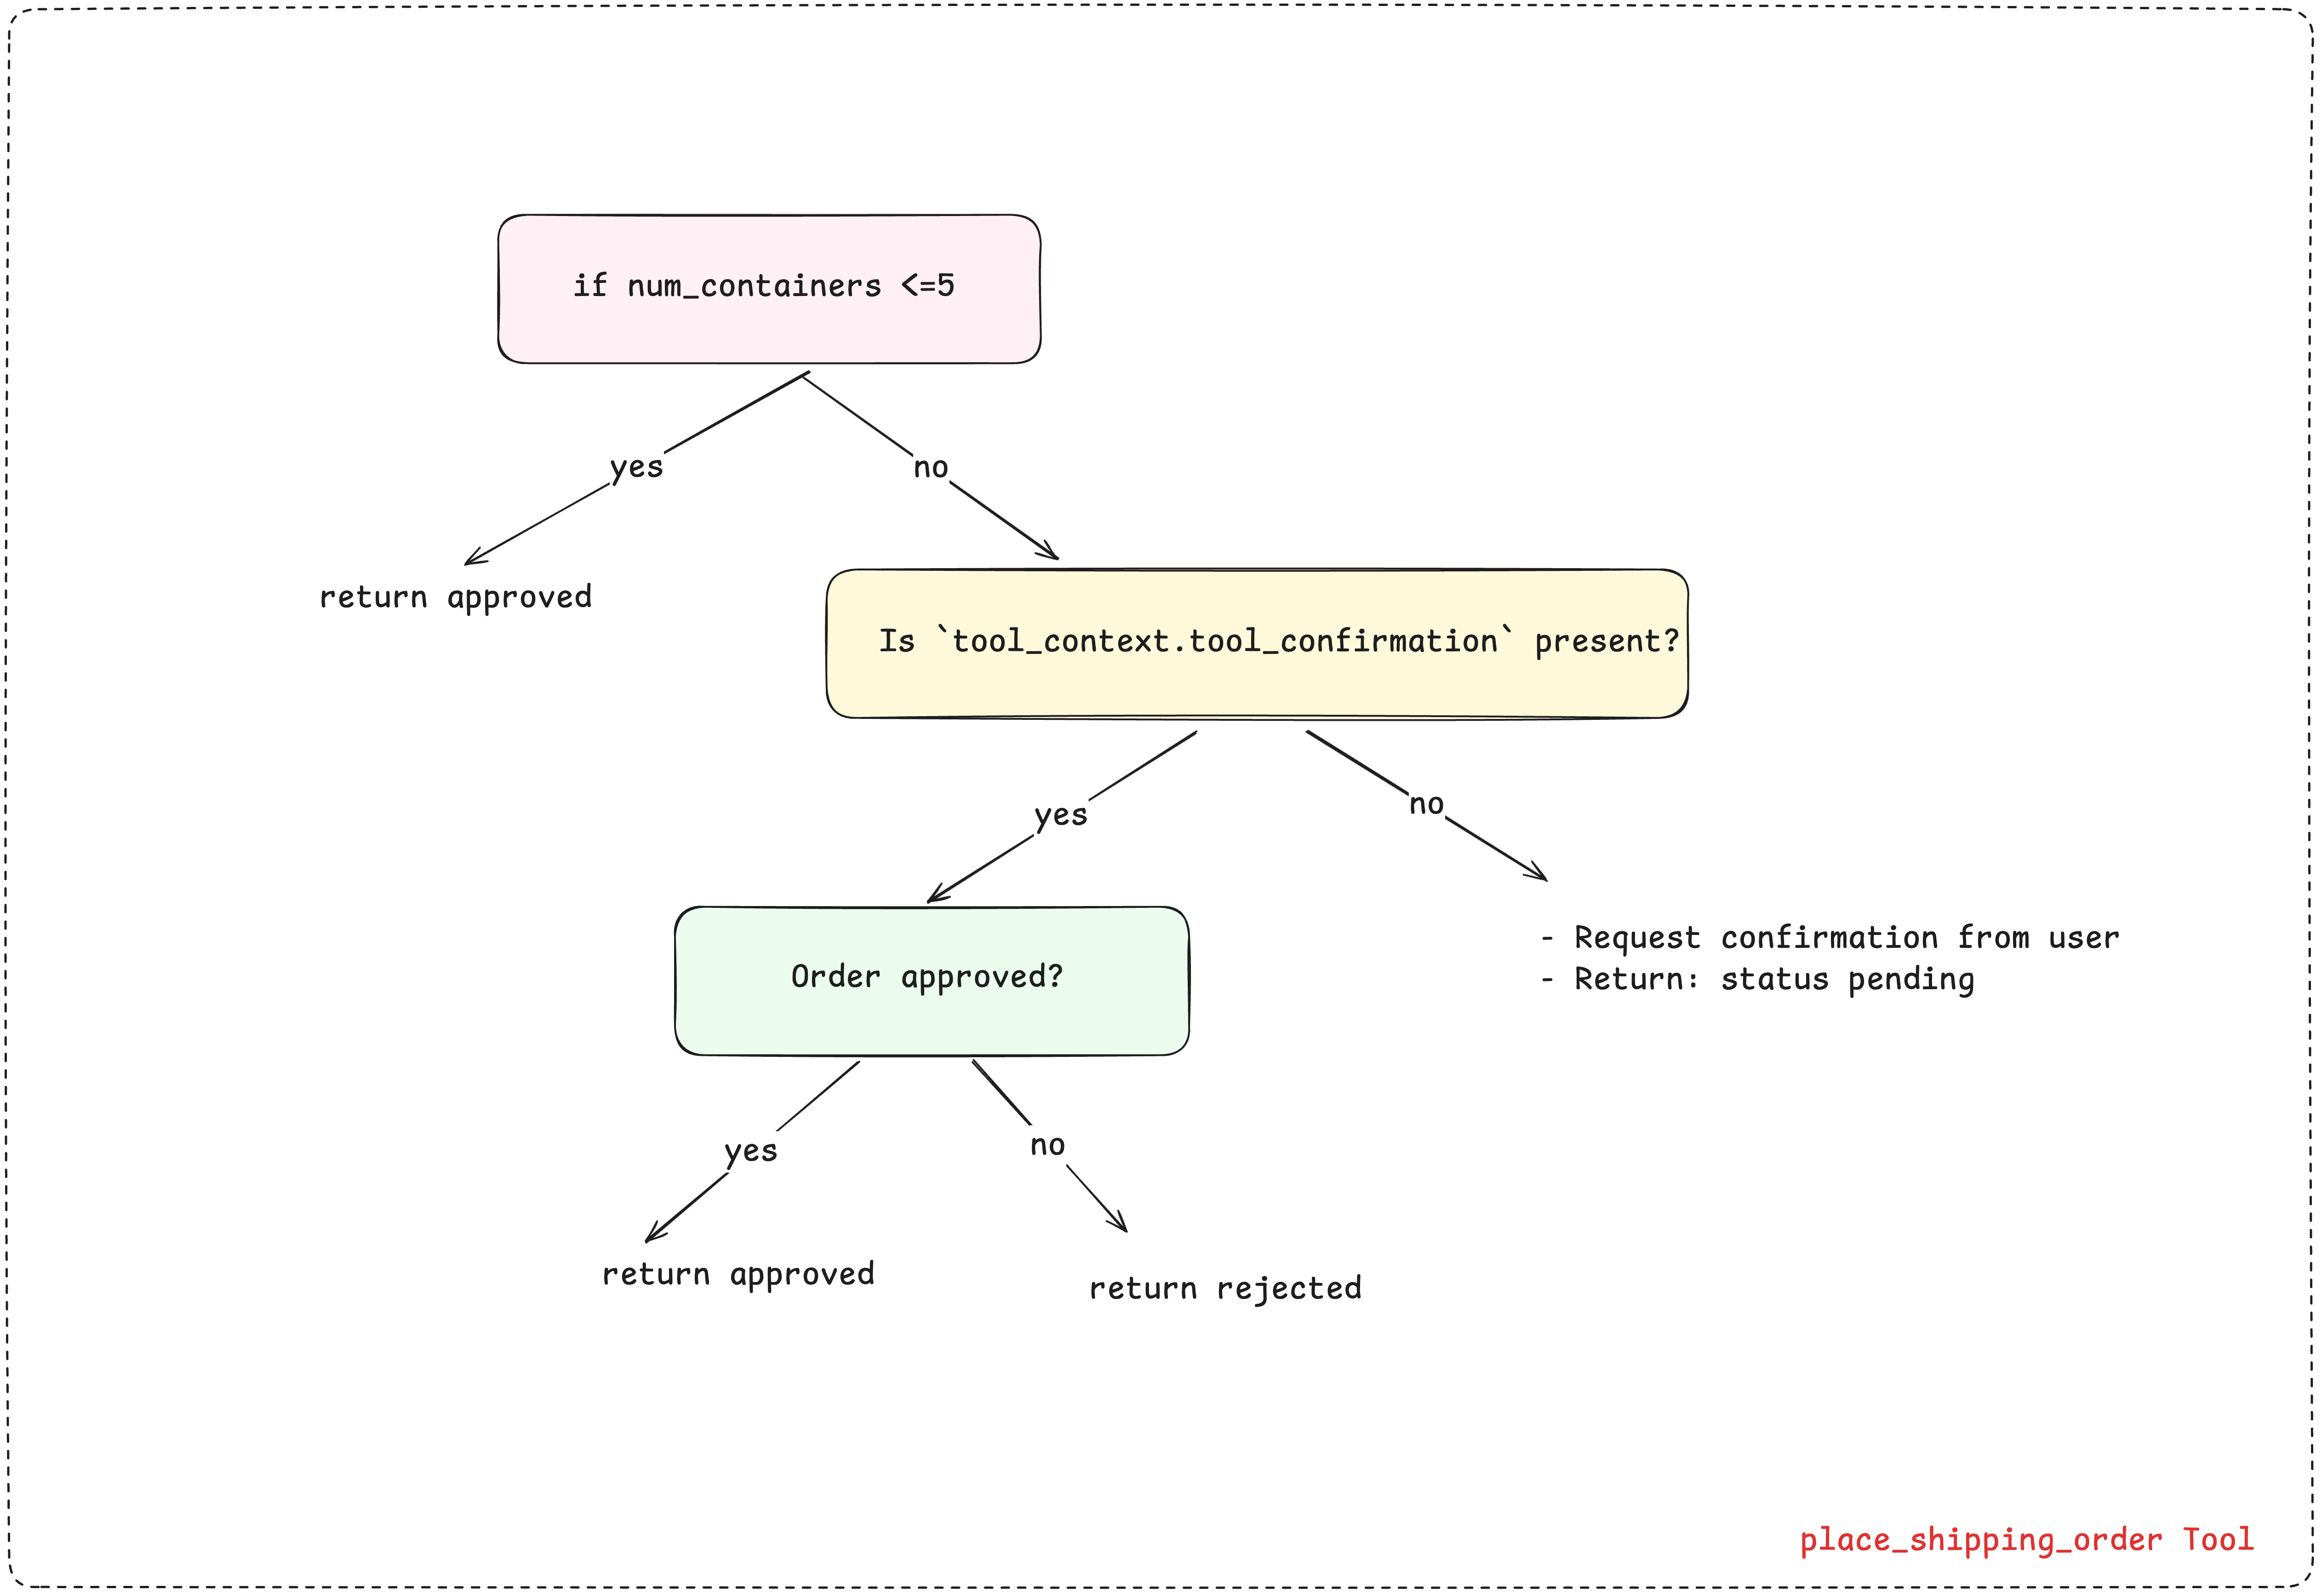

How the Three Scenarios Work¶
The tool handles three scenarios by checking tool_context.tool_confirmation:

Scenario 1: Small order (≤5 containers): Returns immediately with auto-approved status.

tool_context.tool_confirmation is never checked
Scenario 2: Large order - FIRST CALL

Tool detects it's a first call: if not tool_context.tool_confirmation:
Calls request_confirmation() to request human approval
Returns {'status': 'pending', ...} immediately
ADK automatically creates adk_request_confirmation event
Agent execution pauses - waiting for human decision
Scenario 3: Large order - RESUMED CALL

Tool detects it's resuming: if not tool_context.tool_confirmation: is now False
Checks human decision: tool_context.tool_confirmation.confirmed
If True → Returns approved status
If False → Returns rejected status
Key insight: Between the two calls, your workflow code (in Section 4) must detect the adk_request_confirmation event and resume with the approval decision.

3.4: Create the Agent, App and Runner
Step 1: Create the agent

Add the tool to the Agent. The tool decides internally when to request approval based on the order size.

In [19]:
# Create shipping agent with pausable tool
shipping_agent = LlmAgent(
    name="shipping_agent",
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    instruction="""You are a shipping coordinator assistant.
  
  When users request to ship containers:
   1. Use the place_shipping_order tool with the number of containers and destination
   2. If the order status is 'pending', inform the user that approval is required
   3. After receiving the final result, provide a clear summary including:
      - Order status (approved/rejected)
      - Order ID (if available)
      - Number of containers and destination
   4. Keep responses concise but informative
  """,
    tools=[FunctionTool(func=place_shipping_order)],
)

print("✅ Shipping Agent created!")

✅ Shipping Agent created!


Step 2: Wrap in resumable App

The problem: A regular LlmAgent is stateless - each call is independent with no memory of previous interactions. If a tool requests approval, the agent can't remember what it was doing.

The solution: Wrap your agent in an App with resumability enabled. The App adds a persistence layer that saves and restores state.

What gets saved when a tool pauses:

All conversation messages so far
Which tool was called (place_shipping_order)
Tool parameters (10 containers, Rotterdam)
Where exactly it paused (waiting for approval)
When you resume, the App loads this saved state so the agent continues exactly where it left off - as if no time passed.

In [20]:
# Wrap the agent in a resumable app - THIS IS THE KEY FOR LONG-RUNNING OPERATIONS!
shipping_app = App(
    name="shipping_coordinator",
    root_agent=shipping_agent,
    resumability_config=ResumabilityConfig(is_resumable=True),
)

print("✅ Resumable app created!")

✅ Resumable app created!


C:\Users\bernh\AppData\Local\Temp\ipykernel_16632\3673777575.py:5: UserWarning: [EXPERIMENTAL] ResumabilityConfig: This feature is experimental and may change or be removed in future versions without notice. It may introduce breaking changes at any time.
  resumability_config=ResumabilityConfig(is_resumable=True),


Step 3: Create Session and Runner with the App

Pass app=shipping_app instead of agent=... so the runner knows about resumability.

In [21]:
session_service = InMemorySessionService()

# Create runner with the resumable app
shipping_runner = Runner(
    app=shipping_app,  # Pass the app instead of the agent
    session_service=session_service,
)

print("✅ Runner created!")

✅ Runner created!



✅ Recap: Your pausable shipping agent is now complete!

You've created:

✅ A tool that can pause for approval (place_shipping_order)
✅ An agent that uses this tool (shipping_agent)
✅ A resumable app that saves state (shipping_app)
✅ A runner that can handle pause/resume (shipping_runner)
Next step: Build the workflow code and test that our Agent detects pauses and handles approvals.

🏗️ Section 4: Building the Workflow
‼️ Important: The workflow code uses ADK concepts like Sessions, Runners, and Events. We'll cover what you need to know for long-running operations in this notebook. For deeper understanding, we will cover these topics in Day 3, or you can check out the ADK docs and this video.

4.1: ⚠️ The Critical Part - Handling Events in Your Workflow
The agent won't automatically handle pause/resume. Every long-running operation workflow requires you to:

Detect the pause: Check if events contain adk_request_confirmation
Get human decision: In production, show UI and wait for user click. Here, we simulate it.
Resume the agent: Send the decision back with the saved invocation_id
4.2 Understand Key Technical Concepts
👉 events - ADK creates events as the agent executes. Tool calls, model responses, function results - all become events

👉 adk_request_confirmation event - This event is special - it signals "pause here!"

Automatically created by ADK when your tool calls request_confirmation()
Contains the invocation_id
Your workflow must detect this event to know the agent paused
👉 invocation_id - Every call to run_async() gets a unique invocation_id (like "abc123")

When a tool pauses, you save this ID
When resuming, pass the same ID so ADK knows which execution to continue
Without it, ADK would start a NEW execution instead of resuming the paused one
4.3: Helper Functions to Process Events
These handle the event iteration logic for you.

check_for_approval() - Detects if the agent paused

Loops through all events and looks for the special adk_request_confirmation event
Returns approval_id (identifies this specific request) and invocation_id (identifies which execution to resume)
Returns None if no pause detected

In [22]:
def check_for_approval(events):
    """Check if events contain an approval request.

    Returns:
        dict with approval details or None
    """
    for event in events:
        if event.content and event.content.parts:
            for part in event.content.parts:
                if (
                    part.function_call
                    and part.function_call.name == "adk_request_confirmation"
                ):
                    return {
                        "approval_id": part.function_call.id,
                        "invocation_id": event.invocation_id,
                    }
    return None

print_agent_response() - Displays agent text

Simple helper to extract and print text from events

In [23]:
def print_agent_response(events):
    """Print agent's text responses from events."""
    for event in events:
        if event.content and event.content.parts:
            for part in event.content.parts:
                if part.text:
                    print(f"Agent > {part.text}")

create_approval_response() - Formats the human decision

Takes the approval info and boolean decision (True/False) from the human
Creates a FunctionResponse that ADK understands
Wraps it in a Content object to send back to the agent

In [24]:
def create_approval_response(approval_info, approved):
    """Create approval response message."""
    confirmation_response = types.FunctionResponse(
        id=approval_info["approval_id"],
        name="adk_request_confirmation",
        response={"confirmed": approved},
    )
    return types.Content(
        role="user", parts=[types.Part(function_response=confirmation_response)]
    )


print("✅ Helper functions defined")

✅ Helper functions defined


4.4: The Workflow Function - Let's tie it all together!
The run_shipping_workflow() function orchestrates the entire approval flow.

Look for the code explanation in the cell below.

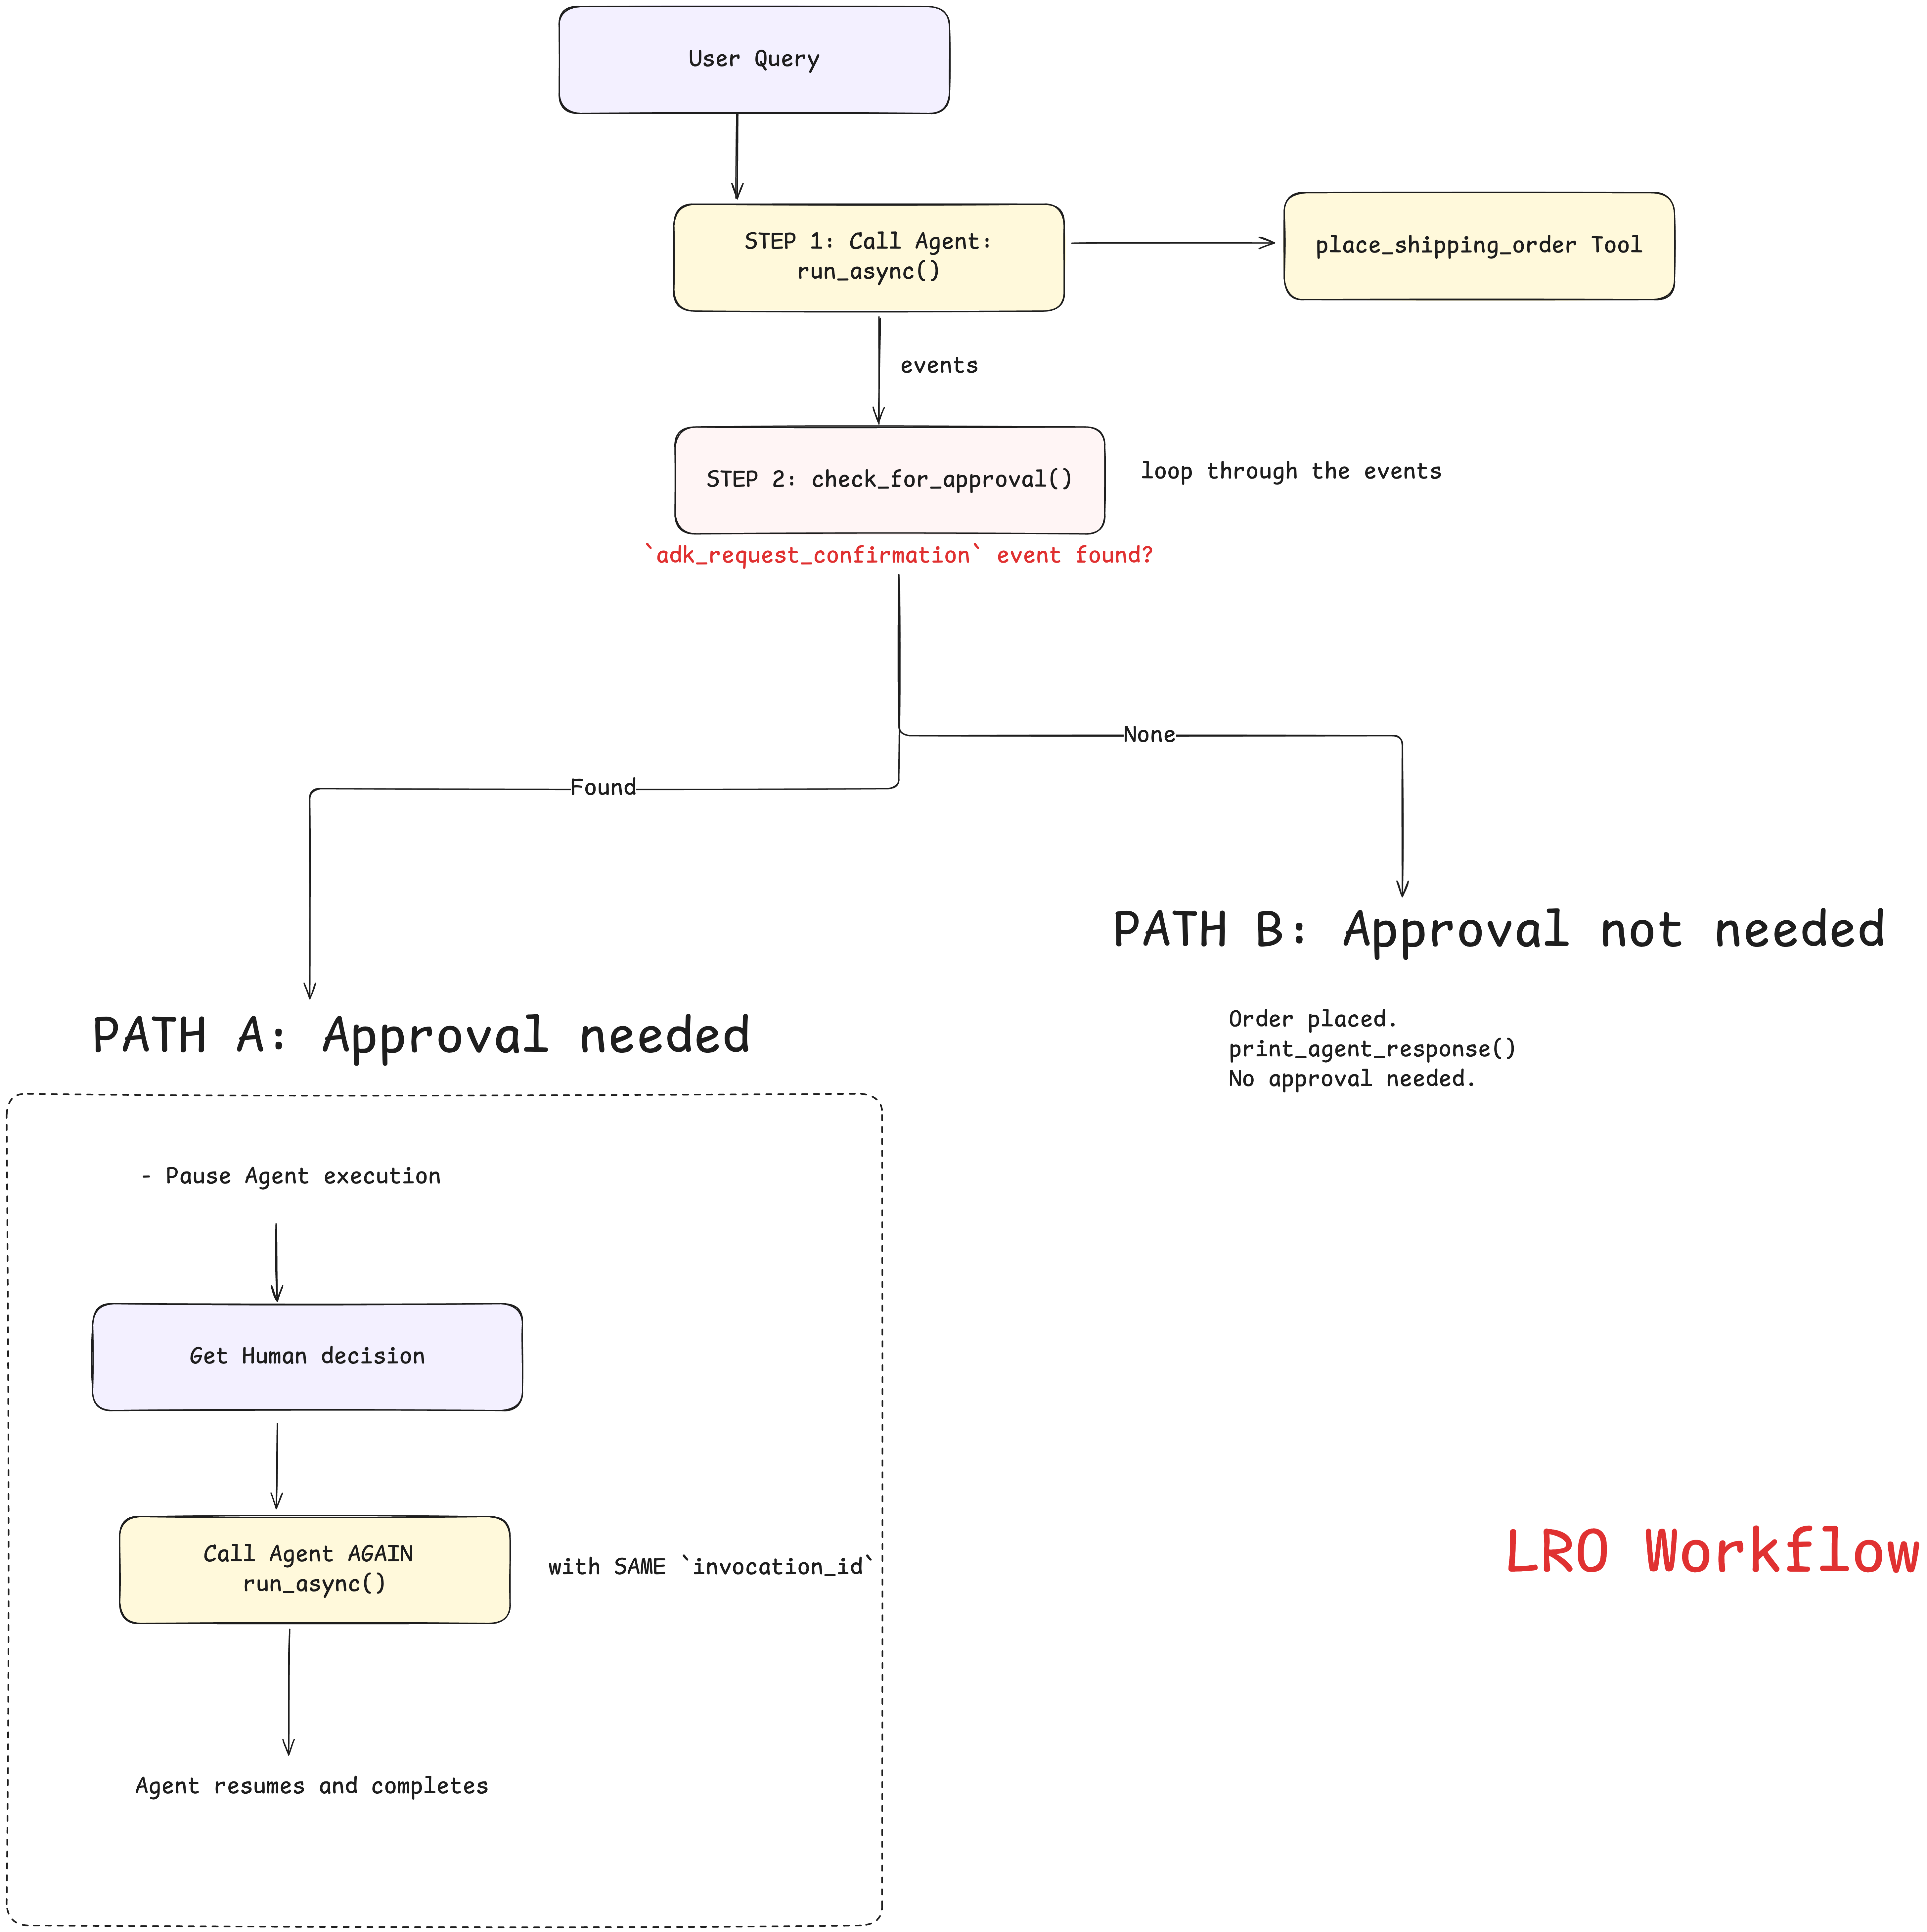


In [25]:
async def run_shipping_workflow(query: str, auto_approve: bool = True):
    """Runs a shipping workflow with approval handling.

    Args:
        query: User's shipping request
        auto_approve: Whether to auto-approve large orders (simulates human decision)
    """

    print(f"\n{'='*60}")
    print(f"User > {query}\n")

    # Generate unique session ID
    session_id = f"order_{uuid.uuid4().hex[:8]}"

    # Create session
    await session_service.create_session(
        app_name="shipping_coordinator", user_id="test_user", session_id=session_id
    )

    query_content = types.Content(role="user", parts=[types.Part(text=query)])
    events = []

    # -----------------------------------------------------------------------------------------------
    # -----------------------------------------------------------------------------------------------
    # STEP 1: Send initial request to the Agent. If num_containers > 5, the Agent returns the special `adk_request_confirmation` event
    async for event in shipping_runner.run_async(
        user_id="test_user", session_id=session_id, new_message=query_content
    ):
        events.append(event)

    # -----------------------------------------------------------------------------------------------
    # -----------------------------------------------------------------------------------------------
    # STEP 2: Loop through all the events generated and check if `adk_request_confirmation` is present.
    approval_info = check_for_approval(events)

    # -----------------------------------------------------------------------------------------------
    # -----------------------------------------------------------------------------------------------
    # STEP 3: If the event is present, it's a large order - HANDLE APPROVAL WORKFLOW
    if approval_info:
        print(f"⏸️  Pausing for approval...")
        print(f"🤔 Human Decision: {'APPROVE ✅' if auto_approve else 'REJECT ❌'}\n")

        # PATH A: Resume the agent by calling run_async() again with the approval decision
        async for event in shipping_runner.run_async(
            user_id="test_user",
            session_id=session_id,
            new_message=create_approval_response(
                approval_info, auto_approve
            ),  # Send human decision here
            invocation_id=approval_info[
                "invocation_id"
            ],  # Critical: same invocation_id tells ADK to RESUME
        ):
            if event.content and event.content.parts:
                for part in event.content.parts:
                    if part.text:
                        print(f"Agent > {part.text}")

    # -----------------------------------------------------------------------------------------------
    # -----------------------------------------------------------------------------------------------
    else:
        # PATH B: If the `adk_request_confirmation` is not present - no approval needed - order completed immediately.
        print_agent_response(events)

    print(f"{'='*60}\n")


print("✅ Workflow function ready")

✅ Workflow function ready


Code breakdown¶
Step 1: Send initial request to the Agent

Call run_async() to start agent execution
Collect all events in a list for inspection
Step 2: Detect Pause

Call check_for_approval(events) to look for the special event: adk_request_confirmation
Returns approval info (with invocation_id) if the special event is present; None if completed
Step 3: Resume execution

PATH A:

If the approval info is present, at this point the Agent pauses for human input.
Once the Human input is available, call the agent again using run_async() and pass in the Human input.
Critical: Same invocation_id (tells ADK to RESUME, not restart)
Display agent's final response after resuming
PATH B:

If the approval info is not present, then approval is not needed and the agent completes execution.
🎬 4.5: Demo: Testing the Workflow
Now, let's run our demos. Notice how much cleaner and easier to read they are. All the complex logic for pausing and resuming is now hidden away in our run_workflow helper function, allowing us to focus on the tasks we want the agent to perform.

Note: You may see warnings like Warning: there are non-text parts in the response: ['function_call'] - this is normal and can be ignored. It just means the agent is calling tools in addition to generating text.

In [26]:
# Demo 1: It's a small order. Agent receives auto-approved status from tool
await run_shipping_workflow("Ship 3 containers to Singapore")

# Demo 2: Workflow simulates human decision: APPROVE ✅
await run_shipping_workflow("Ship 10 containers to Rotterdam", auto_approve=True)

# Demo 3: Workflow simulates human decision: REJECT ❌
await run_shipping_workflow("Ship 8 containers to Los Angeles", auto_approve=False)


User > Ship 3 containers to Singapore



Agent > Transaction approved. 3 containers will be shipped to Singapore. The order ID is ORD-3-AUTO.


User > Ship 10 containers to Rotterdam



c:\Users\bernh\Documentos\GitHub\RagLight\myenv\Lib\site-packages\google\adk\tools\tool_context.py:92: UserWarning: [EXPERIMENTAL] ToolConfirmation: This feature is experimental and may change or be removed in future versions without notice. It may introduce breaking changes at any time.
  ToolConfirmation(
c:\Users\bernh\Documentos\GitHub\RagLight\myenv\Lib\site-packages\google\adk\agents\invocation_context.py:298: UserWarning: [EXPERIMENTAL] BaseAgentState: This feature is experimental and may change or be removed in future versions without notice. It may introduce breaking changes at any time.
  self.agent_states[event.author] = BaseAgentState()


⏸️  Pausing for approval...
🤔 Human Decision: APPROVE ✅

Agent > Shipping order approved. Order ID: ORD-10-HUMAN. 10 containers will be shipped to Rotterdam.


User > Ship 8 containers to Los Angeles



⏸️  Pausing for approval...
🤔 Human Decision: REJECT ❌

Agent > Shipping order rejected: 8 containers to Los Angeles.



4.6: (Optional) Complete execution flow¶
Here's an example trace of the whole workflow.

TL;DR: Tool pauses at TIME 6, workflow detects it at TIME 8, resumes at TIME 10 with same invocation_id="abc123".

Detailed timeline:

Here's what happens step-by-step when you run run_shipping_workflow("Ship 10 containers to Rotterdam", auto_approve=True):

TIME 1: User sends "Ship 10 containers to Rotterdam"
        ↓
TIME 2: Workflow calls shipping_runner.run_async(...)
        ADK assigns a unique invocation_id = "abc123"
        ↓
TIME 3: Agent receives user message, decides to use place_shipping_order tool
        ↓
TIME 4: ADK calls place_shipping_order(10, "Rotterdam", tool_context)
        ↓
TIME 5: Tool checks: num_containers (10) > 5
        Tool calls tool_context.request_confirmation(...)
        ↓
TIME 6: Tool returns {'status': 'pending', ...}
        ↓
TIME 7: ADK creates adk_request_confirmation event with invocation_id="abc123"
        ↓
TIME 8: Workflow detects the event via check_for_approval()
        Saves approval_id and invocation_id="abc123"
        ↓
TIME 9: Workflow gets human decision → True (approve)
        ↓
TIME 10: Workflow calls shipping_runner.run_async(..., invocation_id="abc123")
         Passes approval decision as FunctionResponse
         ↓
TIME 11: ADK sees invocation_id="abc123" - knows to RESUME (instead of starting new)
         Loads saved state from TIME 7
         ↓
TIME 12: ADK calls place_shipping_order again with same parameters
         But now tool_context.tool_confirmation.confirmed = True
         ↓
TIME 13: Tool returns {'status': 'approved', 'order_id': 'ORD-10-HUMAN', ...}
         ↓
TIME 14: Agent receives result and responds to user
Key point: The invocation_id is how ADK knows to resume the paused execution instead of starting a new one.

📊 Section 5: Summary - Key Patterns for Advanced Tools
In this notebook, you implemented two powerful, production-ready patterns for extending your agent's capabilities beyond simple functions.

Pattern	When to Use It	Key ADK Components
MCP Integration	You need to connect to external, standardized services (like time, databases, or file systems) without writing custom integration code.	McpToolset
Long-Running Operations	You need to pause a workflow to wait for an external event, most commonly for human-in-the-loop approvals or long background tasks or for compliance/security checkpoints.	ToolContext, request_confirmation, App, ResumabilityConfig
🚀 Production Ready Concepts
You now understand how to build agents that:

🌐 Scale: Leverage community tools instead of building everything
⏳ Handle Time: Manage operations that span minutes, hours, or days
🔒 Ensure Compliance: Add human oversight to critical operations
🔄 Maintain State: Resume conversations exactly where they paused
Start Simple: Begin with custom tools → Add MCP services → Add long-running as needed

🎯 Exercise: Build an Image Generation Agent with Cost Approval
The scenario:

Build an agent that generates images using the MCP server, but requires approval for "bulk" image generation:

Single image request (1 image): Auto-approve, generate immediately
Bulk request (>1 image): Pause and ask for approval before generating multiple images
Explore different publicly available Image Generation MCP Servers
🎉 Congratulations! You've Learned Agent Patterns and Best Practices
You've successfully learned how to build agents that handle complex, real-world workflows integrating external systems and spanning time.

ℹ️ Note: No submission required!

This notebook is for your hands-on practice and learning only. You do not need to submit it anywhere to complete the course.

📚 Learn More
ADK Documentation
MCP Tools Documentation
Long-Running Operations Guide
Model Context Protocol Specification
The App and Runner
🎯 Next Steps
You've built the foundation for production-ready agent systems. Ready for the next challenge?